In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import copy
import os
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import time
from torchvision import datasets, models, transforms
from pathlib import Path
from typing import Any, cast, Dict, List, Optional, Union
import torchvision.transforms as transforms
import torch.optim as optim

from pprint import pprint

!rm data || rm -rf data
!mkdir data
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

torch.manual_seed(0)
np.random.seed(0)

rm: cannot remove 'data': No such file or directory
PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


In [ ]:
def validate_model(model, dataloader, device = "cuda", trials = 1):

    model.eval()

    dev = torch.device(device)
    model.to(dev)

    run_time = 0
    correct = 0
    total = 0 


    if (device == "cuda"):


      for i, (inputs, labels) in enumerate(dataloader):

        # print(i)

        #print(f"i = {i}")
        start = time.time()

        inputs = inputs.to(dev)
        labels = labels.to(dev)
        # an option can be of not sending the labels to GPU. Instead sending output back from GPU to CPU and getting the prediction on the CPU.

        
        outputs = model(inputs)
        torch.cuda.synchronize()
        # check torch.cuda.current_stream.synchronize()
        end = time.time()
        run_time += end - start
        # outputs = outputs.to("cpu") # an alternative here is ofc to send labels to GPU. 

        _, predicted = torch.max(outputs,1)

        predicted = predicted.to("cpu")
        labels = labels.to("cpu")

        correct += torch.sum(predicted == labels.data)
        total += inputs.size()[0]

        if i % 250 == 249:
          acc_local = 100 * correct.double() / total
          print(f"[{i+1}] accuracy : {acc_local:.4f}%")
        # in for loop
      #in the main fn

      run_time = run_time / trials
      accuracy = 100 * correct.double() / total

      torch.cuda.empty_cache()

    elif (device == "cpu"):
      for i, (inputs, labels) in enumerate(dataloader):

        # print(i)totalzeros = 0
        totalelements = 0
        start = time.time()
        # an option can be of not sending the labels to GPU. Instead sending output back from GPU to CPU and getting the prediction on the CPU.

        
        outputs = model(inputs)
        # check torch.cuda.current_stream.synchronize()
        end = time.time()
        run_time += end - start
        # outputs = outputs.to("cpu") # an alternative here is ofc to send labels to GPU. 

        _, predicted = torch.max(outputs,1)

        correct += torch.sum(predicted == labels.data)
        total += inputs.size()[0]

        if i % 250 == 249:
          acc_local = 100 * correct.double() / total
          print(f"[{i+1}] accuracy : {acc_local:.4f}%")
        # in for loop
      #in the main fn

      run_time = run_time / trials
      accuracy = 100 * correct.double() / total


    return run_time, accuracy

def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    print("Model size: ", model_size)
    return model_size

In [ ]:
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_lin_layers(last_out_channels,num_hidden,num_classes) -> nn.Sequential:

    layers: List[nn.Module] = []
    layers += [nn.Linear(last_out_channels,num_hidden)]
    layers += [nn.ReLU(inplace=True)]
    layers += [nn.Dropout(p=0.5)]
    layers += [nn.Linear(num_hidden, num_hidden)]
    layers += [nn.ReLU(inplace=True)]
    layers += [nn.Dropout(p=0.5)]
    layers += [nn.Linear(num_hidden, num_classes)]

    return nn.Sequential(*layers)

In [ ]:
vgg_19_CIFAR_10_ver1 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg19_bn", pretrained = True)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg19_bn-57191229.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg19_bn-57191229.pt


  0%|          | 0.00/78.5M [00:00<?, ?B/s]

In [ ]:
def plot_weights_VGG19(model1,conv_list1, model2, conv_list2):
    
    for i in range(len(conv_list1)):  
        x1 = model1.features[conv_list1[i]].weight
        sh1 = model1.features[conv_list1[i]].weight.shape
        N1, C1, W1, H1 = sh1[0], sh1[1], sh1[2], sh1[3]
        y1 = x1.view(N1, C1 * W1 * H1)
        x1_new = y1.detach().cpu().numpy()

        x2 = model2.features[conv_list2[i]].weight
        sh2 = model2.features[conv_list2[i]].weight.shape
        N2, C2, W2, H2 = sh2[0], sh2[1], sh2[2], sh2[3]
        y2 = x2.view(N2, C2 * W2 * H2)
        x2_new = y2.detach().cpu().numpy()    

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        fig.set_figwidth(17)
        fig.set_figheight(7)
        ax1.boxplot(x1_new.T,showfliers=False)
        ax2.boxplot(x2_new.T,showfliers=False) 
        plt.show()


    
#     conv2d = conv_list_p
#     # conv2d = [0,3,7,10,14,17,20,23,27,30,33,36,40,43,46,49]
#     fc = [0,3,6] 

#     for i in conv2d:
#       x = model.features[i].weight
#       sh = model.features[i].weight.shape
#       N, C, W, H = sh[0], sh[1], sh[2], sh[3]
#       # print(N, C, W, H)
#       y = x.view(N, C * W * H)
#       # print(y.shape)
#       x_new = y.detach().cpu().numpy()

#       f = plt.figure()
#       f.set_figwidth(30)
#       f.set_figheight(7)

#       plt.title("LAYER: " + str(i))
#       plt.boxplot(x_new.T,showfliers=False)
#       plt.show()

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('Horizontally stacked subplots')
# fig.set_figwidth(15)
# fig.set_figheight(7)
# ax1.plot(x, y)
# ax2.plot(x, -y)


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=4)
                                
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
accu_list = []
size_model = []
sparse_list = []
runtime_list = []

In [ ]:
rn_time, acc = validate_model(vgg_19_CIFAR_10_ver1, testloader,device="cuda")

model_sz = get_size_of_model(vgg_19_CIFAR_10_ver1)

accu_list.append(acc)
runtime_list.append(rn_time)
size_model.append(model_sz)
sparse_list.append(0)

[250] accuracy : 81.4000%
[500] accuracy : 82.1000%
[750] accuracy : 82.1000%
[1000] accuracy : 82.4250%
[1250] accuracy : 81.9600%
[1500] accuracy : 81.4000%
[1750] accuracy : 81.3000%
[2000] accuracy : 81.3625%
[2250] accuracy : 81.3000%
[2500] accuracy : 81.3100%
Model size:  82.338669


In [ ]:
def prune_compr(vgg_19_CIFAR_10, prune_rate_r, num_epochs, model_spars):
    
    conv2d = [0,3,7,10,14,17,20,23,27,30,33,36,40,43,46,49]   # List of conv2d layers numbers
    fc = [0,3,6] 

    convs_to_prune = (
        (vgg_19_CIFAR_10.features[0], 'weight'), # conv1 of VGG19
        (vgg_19_CIFAR_10.features[3], 'weight'), # conv2 of VGG19
        (vgg_19_CIFAR_10.features[7], 'weight'), # conv3 of VGG19
        (vgg_19_CIFAR_10.features[10], 'weight'), # conv4 of VGG19
        (vgg_19_CIFAR_10.features[14], 'weight'), # conv5 of VGG19
        (vgg_19_CIFAR_10.features[17], 'weight'), # conv6 of VGG19
        (vgg_19_CIFAR_10.features[20], 'weight'), # conv7 of VGG19
        (vgg_19_CIFAR_10.features[23], 'weight'), # conv8 of VGG19
        (vgg_19_CIFAR_10.features[27], 'weight'), # conv9 of VGG19
        (vgg_19_CIFAR_10.features[30], 'weight'), # conv10 of VGG19
        (vgg_19_CIFAR_10.features[33], 'weight'), # conv11 of VGG19
        (vgg_19_CIFAR_10.features[36], 'weight'), # conv12 of VGG19
        (vgg_19_CIFAR_10.features[40], 'weight'), # conv13 of VGG19 
        (vgg_19_CIFAR_10.features[43], 'weight'),# conv14 of VGG19 
        (vgg_19_CIFAR_10.features[46], 'weight'), # conv15 of VGG19 
        (vgg_19_CIFAR_10.features[49], 'weight') # conv16 of VGG19 
    )
    #TODO: Add linear layers to prune
    linears_to_prune = (
        (vgg_19_CIFAR_10.classifier[0], 'weight'), # fc1 of VGG19
        (vgg_19_CIFAR_10.classifier[3], 'weight') # f2c of VGG19
    )

    # prune along output
    dimen = 0 
    num_classes = 10

      #TODO: Prune model
    for param, name in convs_to_prune:
        prune.ln_structured(param, name=name, amount=prune_rate_r/100, n=2, dim=dimen)
    for param, name in linears_to_prune:
        prune.ln_structured(param, name=name, amount=prune_rate_r/100, n=2, dim=dimen)

    for param, name in convs_to_prune:
        prune.remove(param, name)
    for param, name in linears_to_prune:
        prune.remove(param, name)


    # rn_time, acc = validate_model(vgg_19_CIFAR_10, testloader,device="cuda")

    print("\n\n===============================\nMODEL SIZE WITHOUT COMPRESSION\n===============================\n\n")
    model_sz = get_size_of_model(vgg_19_CIFAR_10)

    # accu_list.append(acc)
    # runtime_list.append(rn_time)
    size_model.append(model_sz)
    # sparse_list.append(model_spars)


    vgg_19_CIFAR_10_new = copy.deepcopy(vgg_19_CIFAR_10)
    outputs = []                                # List of num of output channels in conv layers
    main_ind = []                               # List of non-zero indexes for conv layers
    make_layer_len = []                         # new conv model config

    # getting num of output channels
    for i in conv2d:
        #print(vgg_19_CIFAR_10.features[i].weight.size()[0])
        outputs.append(vgg_19_CIFAR_10.features[i].weight.size()[0]) #pruning along outputs(dim=0)

    #getting non-zero output channel indexes for conv layers
    for i in range(len(conv2d)):
        non_zero_layer = []                     # List of non-zero indexes for each conv layer
        for y in range(outputs[i]):
            sub_mod = vgg_19_CIFAR_10.features[conv2d[i]].weight[y,:,:,:]
            sub_mod_cloned = sub_mod.clone()
            if(torch.nonzero(sub_mod_cloned).size()[0]!=0):
                non_zero_layer.append(y)

        main_ind.append(non_zero_layer)
        
        #constructing new model config
        if (conv2d[i]==3 or conv2d[i]==10 or conv2d[i]==23 or conv2d[i]==36 or conv2d[i]==49):
            #print(len(non_zero_layer))
            make_layer_len.append(len(non_zero_layer))
            make_layer_len.append("M")
        else:
            #print(len(non_zero_layer))
            make_layer_len.append(len(non_zero_layer))   

    #constructing new features for new model
    tmp_conv_model = make_layers(make_layer_len,batch_norm = True)
    vgg_19_CIFAR_10_new.features = tmp_conv_model

    #storing pruned weights in new conv model
    for i in range(len(main_ind)):
        
        # removing only output channels for first layer
        if (conv2d[i]==0):
            indices_out = torch.tensor(main_ind[i])
            indices_out = indices_out.to("cuda")
            
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]].weight, 0, indices_out)
            new_sub_bias = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]].bias, 0, indices_out)
            
            new_sub_batch_norm_mod = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]+1].weight, 0, indices_out)
            new_sub_batch_norm_bias = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]+1].bias, 0, indices_out)

        # removing input and output channels    
        else:
            indices_out = torch.tensor(main_ind[i])
            indices_out = indices_out.to("cuda")
            
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]].weight, 0, indices_out)
            
            new_sub_batch_norm_mod = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]+1].weight, 0, indices_out)
           
            indices_in = torch.tensor(main_ind[i-1])
            indices_in = indices_in.to("cuda")
            
            new_sub_mod = torch.index_select(new_sub_mod, 1, indices_in)
            new_sub_bias = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]].bias, 0, indices_out)

            new_sub_batch_norm_bias = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]+1].bias, 0, indices_out)

                  
        #assigning the non-zero weights
        vgg_19_CIFAR_10_new.features[conv2d[i]].weight =  torch.nn.Parameter(new_sub_mod)
        vgg_19_CIFAR_10_new.features[conv2d[i]].bias =  torch.nn.Parameter(new_sub_bias)
        vgg_19_CIFAR_10_new.features[conv2d[i]+1].weight =  torch.nn.Parameter(new_sub_batch_norm_mod)
        vgg_19_CIFAR_10_new.features[conv2d[i]+1].bias =  torch.nn.Parameter(new_sub_batch_norm_bias)
        
    main_ind_linear_out = []                               # List of non-zero indexes for linear layers
    make_layer_len_linear_out = []                         # new linear model config

    # getting non-zero output channel indexes for linear layers
    for i in range(len(fc)):
        if (fc[i]==0 or fc[i]==3):                          # omit last layer for output pruning
            non_zero_layer = []                             # List of non-zero indexes for each layer
            for y in range(vgg_19_CIFAR_10.classifier[fc[i]].weight.size()[0]):
                sub_mod = vgg_19_CIFAR_10.classifier[fc[i]].weight[y][:]
                if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):
                    non_zero_layer.append(y)
            
            main_ind_linear_out.append(non_zero_layer)  
            make_layer_len_linear_out.append(len(non_zero_layer)) 

            
    #constructing new classifier for new model
    tmp_lin_model = make_lin_layers(len(main_ind[15]),len(main_ind[15]),num_classes) 
    vgg_19_CIFAR_10_new.classifier = tmp_lin_model
    
    #storing pruned weights in new lin model
    for i in range(len(fc)):
        
        # removing output channels for first layer and input channel wrt conv output
        if (fc[i]==0):
            indices_out = torch.tensor(main_ind_linear_out[i])
            indices_out = indices_out.to("cuda")
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].weight, 0, indices_out)

            out_ind_last_conv =  main_ind[15]

            indices_in = torch.tensor(out_ind_last_conv)
            indices_in = indices_in.to("cuda")
            new_sub_mod = torch.index_select(new_sub_mod, 1, indices_in)

            new_sub_bias = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].bias, 0, indices_out)
        
        #removing input and output channels    
        elif(fc[i]==3):
            indices_out = torch.tensor(main_ind_linear_out[i])
            indices_out = indices_out.to("cuda")
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].weight, 0, indices_out)
            
            indices_in = torch.tensor(main_ind_linear_out[i-1])
            indices_in = indices_in.to("cuda")
            new_sub_mod = torch.index_select(new_sub_mod, 1, indices_in)

            new_sub_bias = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].bias, 0, indices_out)

        # removing only input channels    
        elif(fc[i]==6):
            indices_in = torch.tensor(main_ind_linear_out[i-1])
            indices_in = indices_in.to("cuda")
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].weight, 1, indices_in)
            
            new_sub_bias = vgg_19_CIFAR_10.classifier[fc[i]].bias

        #assigning the non-zero weights
        vgg_19_CIFAR_10_new.classifier[fc[i]].weight =  torch.nn.Parameter(new_sub_mod)
        vgg_19_CIFAR_10_new.classifier[fc[i]].bias =  torch.nn.Parameter(new_sub_bias)

    print("\n\n===============================\nPRUNED MODEL ACCURACY\n===============================\n\n")
    rn_time, acc = validate_model(vgg_19_CIFAR_10_new, testloader,device="cuda")

    print("\n\n===============================\nMODEL SIZE WITH COMPRESSION\n===============================\n\n")
    model_sz = get_size_of_model(vgg_19_CIFAR_10_new)

    accu_list.append(acc)
    runtime_list.append(rn_time)
    size_model.append(model_sz)
    sparse_list.append(model_spars)

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Batch size changed from 4 to 64 as in the paper.
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=False, num_workers=2)
                                    
    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = nn.CrossEntropyLoss() # TODO create criterion
    optimizer = optim.SGD(vgg_19_CIFAR_10_new.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0001) 

    print("\n\n===============================\nTraining model\n===============================\n")
    for epoch in range(num_epochs):
            running_loss = 0.0
            # this allows us to get an index from a foreach loop
            vgg_19_CIFAR_10_new.train()
            dev = torch.device("cuda")
            vgg_19_CIFAR_10_new.to(dev)
            for i, data in enumerate(trainloader, 0):
                # data is a list of [inputs, labels]
                inputs, labels = data
                
                inputs = inputs.to(dev)
                labels = labels.to(dev)  
                # Zero parameter gradients
                optimizer.zero_grad()

                # Go forward, backward then optimize
                outputs = vgg_19_CIFAR_10_new(inputs)   # forward
                loss = criterion(outputs, labels)   # calculate loss
                loss.backward()         # backward
                
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % (100) == (100) - 1:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {(running_loss):.8f}')
                    running_loss = 0.0

    print("\n\n===============================\nRETRAINED MODEL ACCURACY\n===============================\n\n")
    rn_time, acc = validate_model(vgg_19_CIFAR_10_new, testloader,device="cuda")

    accu_list.append(acc)
    runtime_list.append(rn_time)
    sparse_list.append(model_spars)

    return vgg_19_CIFAR_10_new

In [ ]:
prune_rate = 20
model_sparse_full = 100
num_of_epchs = 4

print("===============================\nSPARSITY\n===============================")
sprs = (prune_rate/100)*model_sparse_full 
print("first prune: ",sprs)
vgg_19_CIFAR_10_ver2 = prune_compr(vgg_19_CIFAR_10_ver1, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY
first prune:  20.0


MODEL SIZE WITHOUT COMPRESSION


Model size:  82.338669


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 10.0000%
[500] accuracy : 10.5500%
[750] accuracy : 10.8333%
[1000] accuracy : 10.4500%
[1250] accuracy : 10.2200%
[1500] accuracy : 10.0667%
[1750] accuracy : 10.0571%
[2000] accuracy : 9.9875%
[2250] accuracy : 10.0111%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  52.826477
Files already downloaded and verified


Training model

[1,   100] loss: 93.59976894
[1,   200] loss: 64.95453805
[1,   300] loss: 50.89417759
[1,   400] loss: 47.03514345
[1,   500] loss: 47.24276601
[1,   600] loss: 46.61025360
[1,   700] loss: 41.34370874
[2,   100] loss: 35.88877527
[2,   200] loss: 34.55041515
[2,   300] loss: 30.25117414
[2,   400] loss: 27.62880793
[2,   500] loss: 27.26960839
[2,   600] loss: 27.42466575
[2,   700] loss: 25.83615315
[3,   100] loss: 23.51107639
[3,   200] loss: 21.56094771
[3,   300] loss: 22.16244580
[3,   400] loss: 19.47005938
[3,   500] loss: 20.60828399
[3,   600] loss: 18.98190783
[3,   700] loss: 18.82395715
[4,   100] los

In [ ]:
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nsecond prune: ",sprs)
vgg_19_CIFAR_10_ver3 = prune_compr(vgg_19_CIFAR_10_ver2, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

second prune:  36.0


MODEL SIZE WITHOUT COMPRESSION


Model size:  52.826477


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 10.0000%
[500] accuracy : 10.2000%
[750] accuracy : 10.3333%
[1000] accuracy : 10.5250%
[1250] accuracy : 10.2600%
[1500] accuracy : 10.0667%
[1750] accuracy : 10.1857%
[2000] accuracy : 10.0000%
[2250] accuracy : 10.0111%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  33.846253
Files already downloaded and verified


Training model

[1,   100] loss: 30.62271532
[1,   200] loss: 29.25318771
[1,   300] loss: 25.14842953
[1,   400] loss: 23.51882395
[1,   500] loss: 24.38764191
[1,   600] loss: 25.39493594
[1,   700] loss: 21.47210354
[2,   100] loss: 18.96795898
[2,   200] loss: 17.88285238
[2,   300] loss: 16.36447345
[2,   400] loss: 17.24207572
[2,   500] loss: 15.67970839
[2,   600] loss: 18.29298885
[2,   700] loss: 17.22074603
[3,   100] loss: 15.42776442
[3,   200] loss: 14.17177283
[3,   300] loss: 15.54129932
[3,   400] loss: 14.94057303
[3,   500] loss: 12.31076305
[3,   600] loss: 14.14952445
[3,   700] loss: 12.49968723
[4,   100] lo

In [ ]:
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nthird prune: ",sprs)
vgg_19_CIFAR_10_ver4 = prune_compr(vgg_19_CIFAR_10_ver3, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

third prune:  48.8


MODEL SIZE WITHOUT COMPRESSION


Model size:  33.846253


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.3000%
[500] accuracy : 9.4000%
[750] accuracy : 9.3333%
[1000] accuracy : 9.8500%
[1250] accuracy : 9.9600%
[1500] accuracy : 10.0000%
[1750] accuracy : 10.3857%
[2000] accuracy : 10.2000%
[2250] accuracy : 10.0000%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  21.630701
Files already downloaded and verified


Training model

[1,   100] loss: 29.22919198
[1,   200] loss: 26.95026483
[1,   300] loss: 26.22230971
[1,   400] loss: 25.53728270
[1,   500] loss: 24.45026094
[1,   600] loss: 24.58147064
[1,   700] loss: 21.22083585
[2,   100] loss: 19.34945659
[2,   200] loss: 18.39194872
[2,   300] loss: 16.09892767
[2,   400] loss: 20.15615784
[2,   500] loss: 16.99339508
[2,   600] loss: 15.93897652
[2,   700] loss: 17.20738356
[3,   100] loss: 12.40800577
[3,   200] loss: 14.07874413
[3,   300] loss: 14.01387625
[3,   400] loss: 14.39346770
[3,   500] loss: 14.39491274
[3,   600] loss: 13.14454954
[3,   700] loss: 13.00133368
[4,   100] loss: 1

In [ ]:
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nfourth prune: ",sprs)
vgg_19_CIFAR_10_ver5 = prune_compr(vgg_19_CIFAR_10_ver4, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

fourth prune:  59.04


MODEL SIZE WITHOUT COMPRESSION


Model size:  21.630701


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 11.9000%
[500] accuracy : 10.1500%
[750] accuracy : 10.3667%
[1000] accuracy : 10.1500%
[1250] accuracy : 10.1400%
[1500] accuracy : 10.1667%
[1750] accuracy : 10.2857%
[2000] accuracy : 10.1125%
[2250] accuracy : 9.9778%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  13.919597
Files already downloaded and verified


Training model

[1,   100] loss: 42.15764625
[1,   200] loss: 35.07119435
[1,   300] loss: 32.53564632
[1,   400] loss: 29.75751105
[1,   500] loss: 27.24582256
[1,   600] loss: 27.98178820
[1,   700] loss: 26.97898473
[2,   100] loss: 24.06693556
[2,   200] loss: 20.17243949
[2,   300] loss: 20.65475564
[2,   400] loss: 20.62058135
[2,   500] loss: 19.20675496
[2,   600] loss: 19.81065683
[2,   700] loss: 18.79579265
[3,   100] loss: 17.22876382
[3,   200] loss: 16.51693952
[3,   300] loss: 14.08783561
[3,   400] loss: 16.82760792
[3,   500] loss: 16.32749868
[3,   600] loss: 16.10349268
[3,   700] loss: 14.51599585
[4,   100] los

In [ ]:
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nfifth prune: ",sprs)
vgg_19_CIFAR_10_ver6 = prune_compr(vgg_19_CIFAR_10_ver5, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

fifth prune:  67.232


MODEL SIZE WITHOUT COMPRESSION


Model size:  13.919597


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.6000%
[500] accuracy : 9.9500%
[750] accuracy : 10.1333%
[1000] accuracy : 9.9500%
[1250] accuracy : 9.8000%
[1500] accuracy : 9.9167%
[1750] accuracy : 9.8857%
[2000] accuracy : 9.9375%
[2250] accuracy : 10.0556%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  8.927341
Files already downloaded and verified


Training model

[1,   100] loss: 49.94205020
[1,   200] loss: 41.17279385
[1,   300] loss: 36.55518088
[1,   400] loss: 36.56059610
[1,   500] loss: 34.43478154
[1,   600] loss: 36.46114764
[1,   700] loss: 33.92163327
[2,   100] loss: 27.04852095
[2,   200] loss: 25.49260762
[2,   300] loss: 26.74047022
[2,   400] loss: 23.59711099
[2,   500] loss: 23.67818471
[2,   600] loss: 25.09325815
[2,   700] loss: 26.82483936
[3,   100] loss: 19.37435252
[3,   200] loss: 20.97813251
[3,   300] loss: 18.96893191
[3,   400] loss: 21.64594840
[3,   500] loss: 18.17080164
[3,   600] loss: 21.77737595
[3,   700] loss: 19.54843709
[4,   100] loss: 17.6

In [ ]:
prune_rate = 10
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nsixth prune: ",sprs)
vgg_19_CIFAR_10_ver7 = prune_compr(vgg_19_CIFAR_10_ver6, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

sixth prune:  70.5088


MODEL SIZE WITHOUT COMPRESSION


Model size:  8.927341


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 8.9000%
[500] accuracy : 10.3000%
[750] accuracy : 10.4000%
[1000] accuracy : 10.1750%
[1250] accuracy : 10.1200%
[1500] accuracy : 10.0667%
[1750] accuracy : 10.1857%
[2000] accuracy : 10.2000%
[2250] accuracy : 10.1556%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  7.236589
Files already downloaded and verified


Training model

[1,   100] loss: 32.75706857
[1,   200] loss: 29.63125324
[1,   300] loss: 28.47169177
[1,   400] loss: 28.84792877
[1,   500] loss: 27.58573976
[1,   600] loss: 28.20654738
[1,   700] loss: 26.51367282
[2,   100] loss: 20.97678224
[2,   200] loss: 22.57500986
[2,   300] loss: 20.70830868
[2,   400] loss: 19.95630557
[2,   500] loss: 19.98269094
[2,   600] loss: 21.90048306
[2,   700] loss: 20.44764581
[3,   100] loss: 20.05938401
[3,   200] loss: 18.67524857
[3,   300] loss: 16.82453799
[3,   400] loss: 19.46850108
[3,   500] loss: 18.13337974
[3,   600] loss: 19.53551606
[3,   700] loss: 16.71266888
[4,   100] loss

In [ ]:
prune_rate = 10
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nseventh prune: ",sprs)
vgg_19_CIFAR_10_ver8 = prune_compr(vgg_19_CIFAR_10_ver7, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

seventh prune:  73.45792


MODEL SIZE WITHOUT COMPRESSION


Model size:  7.236589


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.3000%
[500] accuracy : 9.9000%
[750] accuracy : 9.9667%
[1000] accuracy : 10.0000%
[1250] accuracy : 9.9800%
[1500] accuracy : 9.7167%
[1750] accuracy : 9.8571%
[2000] accuracy : 9.8750%
[2250] accuracy : 9.9667%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  5.869805
Files already downloaded and verified


Training model

[1,   100] loss: 37.51469958
[1,   200] loss: 33.77802069
[1,   300] loss: 30.80011812
[1,   400] loss: 29.39209828
[1,   500] loss: 26.28988195
[1,   600] loss: 31.59294643
[1,   700] loss: 28.07302547
[2,   100] loss: 20.90004681
[2,   200] loss: 22.29992558
[2,   300] loss: 22.95139680
[2,   400] loss: 24.58283343
[2,   500] loss: 21.99635362
[2,   600] loss: 24.17816713
[2,   700] loss: 22.14965234
[3,   100] loss: 18.47667469
[3,   200] loss: 18.08961208
[3,   300] loss: 17.13813272
[3,   400] loss: 18.69047802
[3,   500] loss: 15.57260014
[3,   600] loss: 19.05761089
[3,   700] loss: 17.27290643
[4,   100] loss: 18.21

In [ ]:
prune_rate = 10
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\neigth prune: ",sprs)
vgg_19_CIFAR_10_ver9 = prune_compr(vgg_19_CIFAR_10_ver8, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

eigth prune:  76.112128


MODEL SIZE WITHOUT COMPRESSION


Model size:  5.869805


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.9000%
[500] accuracy : 10.3000%
[750] accuracy : 10.1667%
[1000] accuracy : 10.0750%
[1250] accuracy : 10.0200%
[1500] accuracy : 10.1833%
[1750] accuracy : 10.2857%
[2000] accuracy : 10.2875%
[2250] accuracy : 10.1000%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  4.734253
Files already downloaded and verified


Training model

[1,   100] loss: 38.34487734
[1,   200] loss: 33.00046955
[1,   300] loss: 31.58550537
[1,   400] loss: 30.05436622
[1,   500] loss: 29.64534566
[1,   600] loss: 30.40933828
[1,   700] loss: 29.54718080
[2,   100] loss: 25.65885331
[2,   200] loss: 22.71399663
[2,   300] loss: 22.38050988
[2,   400] loss: 21.54098864
[2,   500] loss: 23.11910324
[2,   600] loss: 22.24915789
[2,   700] loss: 21.28794936
[3,   100] loss: 21.11343540
[3,   200] loss: 20.50648167
[3,   300] loss: 20.41902784
[3,   400] loss: 18.53604403
[3,   500] loss: 19.39830416
[3,   600] loss: 21.78782438
[3,   700] loss: 18.99713600
[4,   100] loss

In [ ]:
prune_rate = 10
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nninth prune: ",sprs)
vgg_19_CIFAR_10_ver10 = prune_compr(vgg_19_CIFAR_10_ver9, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

ninth prune:  78.5009152


MODEL SIZE WITHOUT COMPRESSION


Model size:  4.734253


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 10.6000%
[500] accuracy : 10.4000%
[750] accuracy : 10.9000%
[1000] accuracy : 10.8000%
[1250] accuracy : 10.6400%
[1500] accuracy : 10.6000%
[1750] accuracy : 10.3714%
[2000] accuracy : 10.2875%
[2250] accuracy : 10.0667%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  3.856941
Files already downloaded and verified


Training model

[1,   100] loss: 49.49797836
[1,   200] loss: 41.60002401
[1,   300] loss: 36.34056965
[1,   400] loss: 38.49673788
[1,   500] loss: 33.74075530
[1,   600] loss: 33.60027972
[1,   700] loss: 32.10338109
[2,   100] loss: 27.74805415
[2,   200] loss: 27.51166357
[2,   300] loss: 26.02285661
[2,   400] loss: 27.64638888
[2,   500] loss: 24.61990876
[2,   600] loss: 27.12006354
[2,   700] loss: 27.73312243
[3,   100] loss: 26.43052147
[3,   200] loss: 24.83650340
[3,   300] loss: 24.23115404
[3,   400] loss: 23.32583516
[3,   500] loss: 21.63798594
[3,   600] loss: 24.72669221
[3,   700] loss: 21.50961930
[4,   100] los

In [ ]:
new_accu_list = []
for ele in accu_list:
    new_accu_list.append(ele.item())

print(new_accu_list)
print(size_model)
print(sparse_list)
print(runtime_list)

print(len(new_accu_list))
print(len(size_model))
print(len(sparse_list))
print(len(runtime_list))

[81.31, 10.0, 86.95, 10.0, 86.64, 10.0, 85.98, 10.0, 85.95, 10.0, 82.74, 10.0, 83.23, 10.0, 83.55, 10.0, 82.84, 10.0, 82.05]
[82.338669, 82.338669, 52.826477, 52.826477, 33.846253, 33.846253, 21.630701, 21.630701, 13.919597, 13.919597, 8.927341, 8.927341, 7.236589, 7.236589, 5.869805, 5.869805, 4.734253, 4.734253, 3.856941]
[0, 20.0, 20.0, 36.0, 36.0, 48.8, 48.8, 59.04, 59.04, 67.232, 67.232, 70.5088, 70.5088, 73.45792, 73.45792, 76.112128, 76.112128, 78.5009152, 78.5009152]
[18.26541781425476, 11.686237812042236, 11.771500825881958, 11.640605926513672, 11.38049054145813, 10.766676425933838, 10.76389193534851, 10.585808992385864, 10.496739864349365, 10.483405828475952, 10.39548373222351, 10.866823434829712, 10.511677265167236, 10.489964246749878, 10.432687997817993, 10.727457761764526, 10.730249166488647, 10.457821369171143, 10.428009271621704]
19
19
19
19


In [ ]:
new_sparselist = []
[new_sparselist.append(x) for x in sparse_list if x not in new_sparselist]

print(new_sparselist)
print(len(new_sparselist))

new_size_model = []
[new_size_model.append(x) for x in size_model if x not in new_size_model]

print(new_size_model)
print(len(new_size_model))
print()
 

[0, 20.0, 36.0, 48.8, 59.04, 67.232, 70.5088, 73.45792, 76.112128, 78.5009152]
10
[82.338669, 52.826477, 33.846253, 21.630701, 13.919597, 8.927341, 7.236589, 5.869805, 4.734253, 3.856941]
10



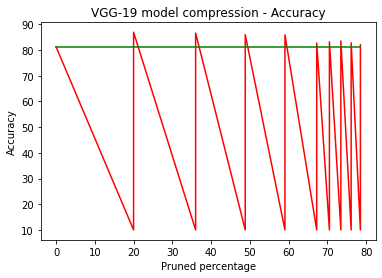

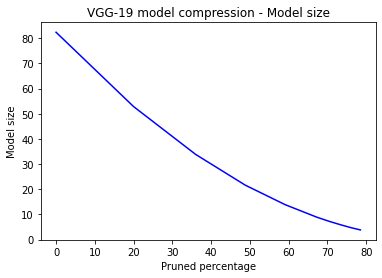

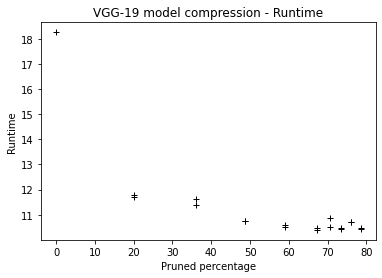

In [ ]:
# importing the modules
import numpy as np
import matplotlib.pyplot as plt

baseline = np.ones(len(new_accu_list))*81.31

# plotting
plt.title("VGG-19 model compression - Accuracy")
plt.xlabel("Pruned percentage")
plt.ylabel("Accuracy")
plt.plot(sparse_list, new_accu_list, color ="red")
plt.plot(sparse_list, baseline, color ="green")
plt.show()

plt.title("VGG-19 model compression - Model size")
plt.xlabel("Pruned percentage")
plt.ylabel("Model size")
plt.plot(new_sparselist, new_size_model, color ="blue")
plt.show()

plt.title("VGG-19 model compression - Runtime")
plt.xlabel("Pruned percentage")
plt.ylabel("Runtime")
plt.plot(sparse_list, runtime_list, 'r+', color ="black")
plt.show()